# RCS simulation testing

In [1]:
import pandas as pd
import numpy as np

#Get password
from getpass import getpass

#Packages for GUIs (widgets) in python
from tkinter import Tk, filedialog
from ipywidgets import *
from IPython.display import clear_output, display

import os

from runeq import Config, stream
from common.utils import rune

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

In [2]:
from ast import literal_eval
import time

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
os.chdir('/home/dlawrence/GitHub/rcs-simulation')
from rcssim import rcs_sim as rcs

In [5]:
os.chdir('/home/dlawrence/GitHub/move-responsive-adbs')
from move_adbs_utils_v1 import *

# Load data

In [6]:
print('Select folder containing data and settings files.')
data_folder = filedialog.askdirectory()

Select folder containing data and settings files.


##### Open file dialog for selecting neural data (.csv)
root = Tk()
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)

print('Select folder containing data and settings files.')
data_folder = filedialog.askdirectory()

root.destroy()

# LD1

### Load measured datasets and settings

In [7]:
# left_neural_data = pd.read_csv(left_file_name)
data_meas = pd.read_csv(data_folder + '/dataset_ld1.csv')
settings = pd.read_csv(data_folder + '/dataset_ld1_config.csv')
amp_gains = np.genfromtxt(data_folder + '/amp_gains.csv', 
                          delimiter=',').astype(int)

settings['band_edges_hz'] = settings['band_edges_hz'].apply(literal_eval)
settings['subtract_vec'] = settings['subtract_vec'].apply(literal_eval)
settings['multiply_vec'] = settings['multiply_vec'].apply(literal_eval)
settings['update_rate'] = settings['update_rate'].apply(literal_eval)
settings['weights'] = settings['weights'].apply(literal_eval)
# settings['dual_threshold'] = settings['dual_threshold'].apply(literal_eval)
settings['threshold'] = settings['threshold'].apply(literal_eval)
settings['blank_duration'] = settings['blank_duration'].apply(literal_eval)
settings['onset'] = settings['onset'].apply(literal_eval)
settings['termination'] = settings['termination'].apply(literal_eval)
settings['blank_both'] = settings['blank_both'] #.apply(literal_eval)
# settings['target_amp'] = settings['target_amp'].apply(literal_eval)

In [8]:
print('Measured data')
data_meas.head(2)

Measured data


,timestamp,td1,td2,pb1,pb2,ld1,ld2
0,0.000,-0.251836,-0.160516,NaN,NaN,NaN,NaN
1,0.002,-0.311771,-0.236978,NaN,NaN,NaN,NaN


In [9]:
print('Settings')
settings

Settings


,fs_td,fft_size,interval,bit_shift,band_edges_hz,subtract_vec,multiply_vec,update_rate,weights,threshold,blank_duration,onset,termination,blank_both
0,500,256,200,3,"[[28.32, 30.27], [28.32, 30.27]]","[[1120000, 590000], [1120000, 590000]]","[[0.09, 0.2], [0.09, 0.2]]","[5, 2]","[[3, 2], [2, -1]]","[[104850, 104851], [104850, 104851]]","[0, 0]","[1, 1]","[1, 1]",0


### TD --> PB

In [10]:
data_sim = data_meas[['timestamp', 'td1', 'td2']].copy()
data_sim['pb1'] = np.nan*np.ones(np.shape(data_sim['td1']))
data_sim['pb2'] = np.nan*np.ones(np.shape(data_sim['td1']))

t_start = time.time()
hann_win = rcs.create_hann_window(settings.fft_size[0], percent=100)

# Compute power band for the first time-domain channel
data_td = rcs.transform_mv_to_rcs(data_sim['td1'].values, amp_gains[0])
data_fft, t_pb = rcs.td_to_fft(data_td, 
                               data_sim['timestamp'].values, settings.fs_td[0], 
                               settings.fft_size[0], settings.interval[0], 
                               hann_win, output_in_mv=False)
data_pb = rcs.fft_to_pb(data_fft, settings.fs_td[0], settings.fft_size[0], 
                        settings.bit_shift[0], 
                        band_edges_hz=settings.band_edges_hz[0][0], 
                        input_is_mv=False)
pb_sample_mask = np.isin(data_sim.timestamp, t_pb)
data_sim.loc[pb_sample_mask,'pb1'] = data_pb

# Compute power band for the second time-domain channel
data_td = rcs.transform_mv_to_rcs(data_sim['td2'].values, amp_gains[1])
data_fft, t_pb = rcs.td_to_fft(data_td, 
                               data_sim['timestamp'].values, settings.fs_td[0], 
                               settings.fft_size[0], settings.interval[0], 
                               hann_win, output_in_mv=False)
data_pb = rcs.fft_to_pb(data_fft, settings.fs_td[0], settings.fft_size[0], 
                        settings.bit_shift[0], 
                        band_edges_hz=settings.band_edges_hz[0][1], 
                        input_is_mv=False)
pb_sample_mask = np.isin(data_sim.timestamp, t_pb)
data_sim.loc[pb_sample_mask,'pb2'] = data_pb

t_end = time.time()
print('Time elapsed: ' + str(t_end-t_start))

Time elapsed: 0.05325198173522949


In [11]:
data_meas.head(2)

,timestamp,td1,td2,pb1,pb2,ld1,ld2
0,0.000,-0.251836,-0.160516,NaN,NaN,NaN,NaN
1,0.002,-0.311771,-0.236978,NaN,NaN,NaN,NaN


In [12]:
data_sim.head(2)

,timestamp,td1,td2,pb1,pb2
0,0.000,-0.251836,-0.160516,NaN,NaN
1,0.002,-0.311771,-0.236978,NaN,NaN


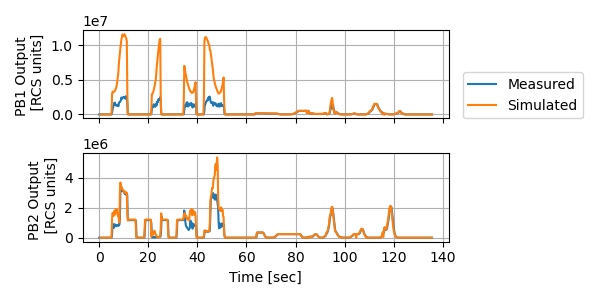

In [13]:
%matplotlib widget
fig, ax = plt.subplots(2,1, figsize=(6,3), sharex='col', sharey=False)

ax[0].plot(data_meas.loc[~np.isnan(data_meas.pb1), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.pb1), 'pb1'], label='Measured')
ax[0].plot(data_sim.loc[~np.isnan(data_sim.pb1), 'timestamp'], 
           data_sim.loc[~np.isnan(data_sim.pb1), 'pb1'], label='Simulated')
ax[0].legend(bbox_to_anchor=(1.02, 0.6))

ax[1].plot(data_meas.loc[~np.isnan(data_meas.pb1), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.pb1), 'pb2'], label='Measured')
ax[1].plot(data_sim.loc[~np.isnan(data_sim.pb1), 'timestamp'], 
           data_sim.loc[~np.isnan(data_sim.pb1), 'pb2'], label='Simulated')

ax[0].grid()
ax[1].grid()
ax[1].set_xlabel('Time [sec]')
ax[0].set_ylabel('PB1 Output \n [RCS units]')
ax[1].set_ylabel('PB2 Output \n [RCS units]')

plt.tight_layout()

### PB --> LD

In [14]:
data_sim['ld1_iso'] = np.nan*np.ones(np.shape(data_sim['td1']))
data_sim['ld2_iso'] = np.nan*np.ones(np.shape(data_sim['td1']))
data_sim['state_iso'] = np.nan*np.ones(np.shape(data_sim['td1']))
data_sim['stim_iso'] = np.nan*np.ones(np.shape(data_sim['td1']))

t_start = time.time()

# Compute continuous-valued LD output
ld_output, t_ld, update_tbl = rcs.pb_to_ld(
                                        data_meas.loc[~np.isnan(data_meas['pb1']), 
                                                      ['pb1', 'pb2']].values, 
                                        data_meas.loc[~np.isnan(data_meas['pb1']), 
                                                      'timestamp'].values, 
                                        update_rate=settings.update_rate[0], 
                                        weights=settings.weights[0],
                                        subtract_vec=settings.subtract_vec[0], 
                                        multiply_vec=settings.multiply_vec[0])

# Log the simulated data
ld1_sample_mask = np.isin(data_sim.timestamp.values, t_ld[0])
data_sim.loc[ld1_sample_mask,'ld1_iso'] = ld_output[0]

ld2_sample_mask = np.isin(data_sim.timestamp.values, t_ld[1])
data_sim.loc[ld2_sample_mask,'ld2_iso'] = ld_output[1]

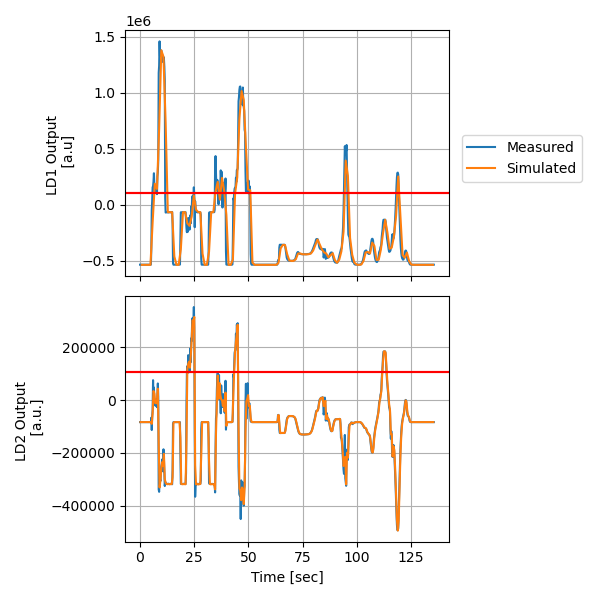

In [15]:
# %matplotlib widget
fig, ax = plt.subplots(2,1, figsize=(6,6), sharex='col', sharey=False)

ax[0].plot(data_meas.loc[~np.isnan(data_meas.ld1), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.ld1), 'ld1'], label='Measured')
ax[0].plot(data_sim.loc[~np.isnan(data_sim.ld1_iso), 'timestamp'], 
           data_sim.loc[~np.isnan(data_sim.ld1_iso), 'ld1_iso'], 
           label='Simulated')
ax[0].axhline(settings.threshold[0][0][0], color='r')
ax[0].axhline(settings.threshold[0][0][1], color='r')
ax[0].legend(bbox_to_anchor=(1.02, 0.6))

ax[1].plot(data_meas.loc[~np.isnan(data_meas.ld2), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.ld2), 'ld2'], label='Measured')
ax[1].plot(data_sim.loc[~np.isnan(data_sim.ld2_iso), 'timestamp'], 
           data_sim.loc[~np.isnan(data_sim.ld2_iso), 'ld2_iso'], 
           label='Simulated')
ax[1].axhline(settings.threshold[0][1][0], color='r')
ax[1].axhline(settings.threshold[0][1][1], color='r')

for i in range(2):
    ax[i].grid()
ax[1].set_xlabel('Time [sec]')
ax[0].set_ylabel('LD1 Output \n [a.u]')
ax[1].set_ylabel('LD2 Output \n [a.u.]')

plt.tight_layout()

# LD2

### Load measured datasets and settings

In [16]:
# left_neural_data = pd.read_csv(left_file_name)
data_meas = pd.read_csv(data_folder + '/dataset_ld2.csv')
settings = pd.read_csv(data_folder + '/dataset_ld2_config.csv')
amp_gains = np.genfromtxt(data_folder + '/amp_gains.csv', 
                          delimiter=',').astype(int)

settings['band_edges_hz'] = settings['band_edges_hz'].apply(literal_eval)
settings['subtract_vec'] = settings['subtract_vec'].apply(literal_eval)
settings['multiply_vec'] = settings['multiply_vec'].apply(literal_eval)
settings['update_rate'] = settings['update_rate'].apply(literal_eval)
settings['weights'] = settings['weights'].apply(literal_eval)
settings['dual_threshold'] = [[True, True]] #settings['dual_threshold'].apply(literal_eval)
settings['threshold'] = settings['threshold'].apply(literal_eval)
settings['blank_duration'] = settings['blank_duration'].apply(literal_eval)
settings['onset'] = settings['onset'].apply(literal_eval)
settings['termination'] = settings['termination'].apply(literal_eval)
settings['blank_both'] = settings['blank_both'] #.apply(literal_eval)
# settings['target_amp'] = settings['target_amp'].apply(literal_eval)

In [17]:
print('Measured data')
data_meas.head(2)

Measured data


,timestamp,td1,td2,pb1,pb2,ld1,ld2,state
0,0.000,-0.197300,-0.169301,NaN,NaN,NaN,NaN,NaN
1,0.002,-0.232181,-0.134920,NaN,NaN,NaN,NaN,NaN


In [18]:
print('Settings')
settings

Settings


,fs_td,fft_size,interval,bit_shift,band_edges_hz,subtract_vec,multiply_vec,update_rate,weights,threshold,blank_duration,onset,termination,blank_both,dual_threshold
0,500,256,200,3,"[[28.32, 30.27], [28.32, 30.27]]","[[1120000, 590000], [1120000, 590000]]","[[0.09, 0.2], [0.09, 0.2]]","[1, 1]","[[3, 2], [2, -1]]","[[104850, 104851], [104850, 104851]]","[0, 20]","[1, 1]","[1, 1]",0,"[True, True]"


### TD --> PB

In [19]:
data_sim = data_meas[['timestamp', 'td1', 'td2']].copy()
data_sim['pb1'] = np.nan*np.ones(np.shape(data_sim['td1']))
data_sim['pb2'] = np.nan*np.ones(np.shape(data_sim['td1']))

t_start = time.time()
hann_win = rcs.create_hann_window(settings.fft_size[0], percent=100)

# Compute power band for the first time-domain channel
data_td = rcs.transform_mv_to_rcs(data_sim['td1'].values, amp_gains[0])
data_fft, t_pb = rcs.td_to_fft(data_td, 
                               data_sim['timestamp'].values, settings.fs_td[0], 
                               settings.fft_size[0], settings.interval[0], 
                               hann_win, output_in_mv=False)
data_pb = rcs.fft_to_pb(data_fft, settings.fs_td[0], settings.fft_size[0], 
                        settings.bit_shift[0], 
                        band_edges_hz=settings.band_edges_hz[0][0], 
                        input_is_mv=False)
pb_sample_mask = np.isin(data_sim.timestamp, t_pb)
data_sim.loc[pb_sample_mask,'pb1'] = data_pb

# Compute power band for the second time-domain channel
data_td = rcs.transform_mv_to_rcs(data_sim['td2'].values, amp_gains[1])
data_fft, t_pb = rcs.td_to_fft(data_td, 
                               data_sim['timestamp'].values, settings.fs_td[0], 
                               settings.fft_size[0], settings.interval[0], 
                               hann_win, output_in_mv=False)
data_pb = rcs.fft_to_pb(data_fft, settings.fs_td[0], settings.fft_size[0], 
                        settings.bit_shift[0], 
                        band_edges_hz=settings.band_edges_hz[0][1], 
                        input_is_mv=False)
pb_sample_mask = np.isin(data_sim.timestamp, t_pb)
data_sim.loc[pb_sample_mask,'pb2'] = data_pb

t_end = time.time()
print('Time elapsed: ' + str(t_end-t_start))

Time elapsed: 0.038491010665893555


In [20]:
data_meas.head(2)

,timestamp,td1,td2,pb1,pb2,ld1,ld2,state
0,0.000,-0.197300,-0.169301,NaN,NaN,NaN,NaN,NaN
1,0.002,-0.232181,-0.134920,NaN,NaN,NaN,NaN,NaN


In [21]:
data_sim.head(2)

,timestamp,td1,td2,pb1,pb2
0,0.000,-0.197300,-0.169301,NaN,NaN
1,0.002,-0.232181,-0.134920,NaN,NaN


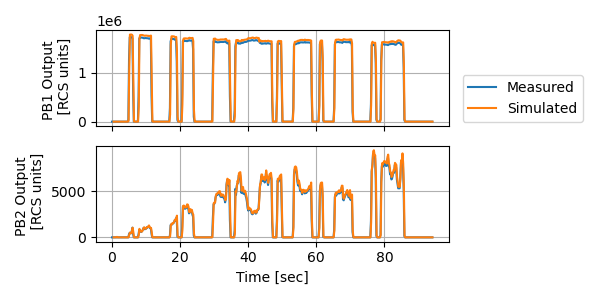

In [22]:
%matplotlib widget
fig, ax = plt.subplots(2,1, figsize=(6,3), sharex='col', sharey=False)

ax[0].plot(data_meas.loc[~np.isnan(data_meas.pb1), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.pb1), 'pb1'], label='Measured')
ax[0].plot(data_sim.loc[~np.isnan(data_sim.pb1), 'timestamp'], 
           data_sim.loc[~np.isnan(data_sim.pb1), 'pb1'], label='Simulated')
ax[0].legend(bbox_to_anchor=(1.02, 0.6))

ax[1].plot(data_meas.loc[~np.isnan(data_meas.pb1), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.pb1), 'pb2'], label='Measured')
ax[1].plot(data_sim.loc[~np.isnan(data_sim.pb1), 'timestamp'], 
           data_sim.loc[~np.isnan(data_sim.pb1), 'pb2'], label='Simulated')

ax[0].grid()
ax[1].grid()
ax[1].set_xlabel('Time [sec]')
ax[0].set_ylabel('PB1 Output \n [RCS units]')
ax[1].set_ylabel('PB2 Output \n [RCS units]')

plt.tight_layout()

### PB --> LD --> state

In [23]:
data_sim['ld1_iso'] = np.nan*np.ones(np.shape(data_sim['td1']))
data_sim['ld2_iso'] = np.nan*np.ones(np.shape(data_sim['td1']))
data_sim['state_iso'] = np.nan*np.ones(np.shape(data_sim['td1']))
data_sim['stim_iso'] = np.nan*np.ones(np.shape(data_sim['td1']))

# Compute continuous-valued LD output
ld_output, t_ld, update_tbl = rcs.pb_to_ld(
                                        data_meas.loc[~np.isnan(data_meas['pb1']), 
                                                      ['pb1', 'pb2']].values, 
                                        data_meas.loc[~np.isnan(data_meas['pb1']), 
                                                      'timestamp'].values, 
                                        update_rate=settings.update_rate[0], 
                                        weights=settings.weights[0],
                                        subtract_vec=settings.subtract_vec[0], 
                                        multiply_vec=settings.multiply_vec[0])

# Compute the state changes
state, t_state, ld_output = rcs.ld_to_state(ld_output, update_tbl, 
                                   data_meas.loc[~np.isnan(data_meas['pb1']), 
                                                 'timestamp'].values, 
                                   update_rate=settings.update_rate[0], 
                                   dual_threshold=settings.dual_threshold[0], 
                                   threshold=settings.threshold[0], 
                                   onset_duration=settings.onset[0], 
                                   termination_duration=settings.termination[0], 
                                   blank_duration=settings.blank_duration[0])

# Log the simulated data
ld1_sample_mask = np.isin(data_sim.timestamp.values, t_ld[0])
data_sim.loc[ld1_sample_mask,'ld1_iso'] = ld_output[0]

ld2_sample_mask = np.isin(data_sim.timestamp.values, t_ld[1])
data_sim.loc[ld2_sample_mask,'ld2_iso'] = ld_output[1]

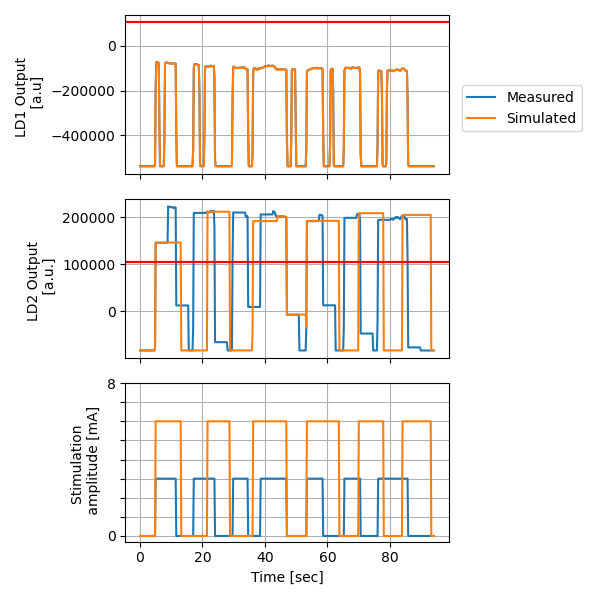

In [24]:
# %matplotlib widget
fig, ax = plt.subplots(3,1, figsize=(6,6), sharex='col', sharey=False)

ax[0].plot(data_meas.loc[~np.isnan(data_meas.ld1), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.ld1), 'ld1'], label='Measured')
ax[0].plot(data_sim.loc[~np.isnan(data_sim.ld1_iso), 'timestamp'], 
           data_sim.loc[~np.isnan(data_sim.ld1_iso), 'ld1_iso'], 
           label='Simulated')
ax[0].axhline(settings.threshold[0][0][0], color='r')
ax[0].axhline(settings.threshold[0][0][1], color='r')
ax[0].legend(bbox_to_anchor=(1.02, 0.6))

ax[1].plot(data_meas.loc[~np.isnan(data_meas.ld2), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.ld2), 'ld2'], label='Measured')
ax[1].plot(data_sim.loc[~np.isnan(data_sim.ld2_iso), 'timestamp'], 
           data_sim.loc[~np.isnan(data_sim.ld2_iso), 'ld2_iso'], 
           label='Simulated')
ax[1].axhline(settings.threshold[0][1][0], color='r')
ax[1].axhline(settings.threshold[0][1][1], color='r')

ax[2].plot(data_meas.loc[~np.isnan(data_meas.state), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.state), 'state'], label='Measured')
# ax[2].plot(data_sim.loc[~np.isnan(data_sim.state_iso), 'timestamp'], 
#            data_sim.loc[~np.isnan(data_sim.state_iso), 'state_iso'], 
#            label='Simulated')
ax[2].plot(t_state, state, 
           label='Simulated')
ax[2].set_yticks(np.arange(9))
ax[2].set_yticklabels(['0'] + ['']*7 + ['8'])

for i in range(3):
    ax[i].grid()
ax[2].set_xlabel('Time [sec]')
ax[0].set_ylabel('LD1 Output \n [a.u]')
ax[1].set_ylabel('LD2 Output \n [a.u.]')
ax[2].set_ylabel('LD State')
ax[2].set_ylabel('Stimulation \n amplitude [mA]')

plt.tight_layout()

# LD3

### Load measured datasets and settings

In [25]:
# left_neural_data = pd.read_csv(left_file_name)
data_meas = pd.read_csv(data_folder + '/dataset_ld3.csv')
settings = pd.read_csv(data_folder + '/dataset_ld3_config.csv')
amp_gains = np.genfromtxt(data_folder + '/amp_gains.csv', 
                          delimiter=',').astype(int)

In [26]:
settings

,fs_td,fft_size,interval,bit_shift,band_edges_hz,subtract_vec,multiply_vec,update_rate,weights,threshold,blank_duration,onset,termination,blank_both
0,500,256,200,3,"[[28.32, 30.27]]",[[1120000]],[[0.09]],[1],[[1]],"[[10000, 10001]]",[0],[15],[20],[0]


In [27]:
settings['band_edges_hz'] = settings['band_edges_hz'].apply(literal_eval)
settings['subtract_vec'] = settings['subtract_vec'].apply(literal_eval)
settings['multiply_vec'] = settings['multiply_vec'].apply(literal_eval)
settings['update_rate'] = settings['update_rate'].apply(literal_eval)
settings['weights'] = [[[1], []]] #settings['weights'].apply(literal_eval)
settings['dual_threshold'] = [[True, True]] #settings['dual_threshold'].apply(literal_eval)
settings['threshold'] = settings['threshold'].apply(literal_eval)
settings['blank_duration'] = settings['blank_duration'].apply(literal_eval)
settings['onset'] = settings['onset'].apply(literal_eval)
settings['termination'] = settings['termination'].apply(literal_eval)
settings['blank_both'] = settings['blank_both'][0] #.apply(literal_eval)
# settings['target_amp'] = settings['target_amp'].apply(literal_eval)

In [29]:
print('Measured data')
data_meas.head(2)

Measured data


,timestamp,td1,pb1,ld1,state
0,70.418,-0.247192,NaN,NaN,NaN
1,70.420,-0.274946,NaN,NaN,NaN


In [30]:
print('Settings')
settings

Settings


,fs_td,fft_size,interval,bit_shift,band_edges_hz,subtract_vec,multiply_vec,update_rate,weights,threshold,blank_duration,onset,termination,blank_both,dual_threshold
0,500,256,200,3,"[[28.32, 30.27]]",[[1120000]],[[0.09]],[1],"[[1], []]","[[10000, 10001]]",[0],[15],[20],[0],"[True, True]"


### TD --> PB

In [31]:
data_sim = data_meas[['timestamp', 'td1']].copy()
data_sim['pb1'] = np.nan*np.ones(np.shape(data_sim['td1']))

t_start = time.time()
hann_win = rcs.create_hann_window(settings.fft_size[0], percent=100)

# Compute power band for the first time-domain channel
data_td = rcs.transform_mv_to_rcs(data_sim['td1'].values, amp_gains[0])
data_fft, t_pb = rcs.td_to_fft(data_td, 
                               data_sim['timestamp'].values, settings.fs_td[0], 
                               settings.fft_size[0], settings.interval[0], 
                               hann_win, output_in_mv=False)
data_pb = rcs.fft_to_pb(data_fft, settings.fs_td[0], settings.fft_size[0], 
                        settings.bit_shift[0], 
                        band_edges_hz=settings.band_edges_hz[0][0], 
                        input_is_mv=False)
pb_sample_mask = np.isin(data_sim.timestamp, t_pb)
data_sim.loc[pb_sample_mask,'pb1'] = data_pb

t_end = time.time()
print('Time elapsed: ' + str(t_end-t_start))

Time elapsed: 0.01445627212524414


In [32]:
data_meas.head(2)

,timestamp,td1,pb1,ld1,state
0,70.418,-0.247192,NaN,NaN,NaN
1,70.420,-0.274946,NaN,NaN,NaN


In [33]:
data_sim.head(2)

,timestamp,td1,pb1
0,70.418,-0.247192,NaN
1,70.420,-0.274946,NaN


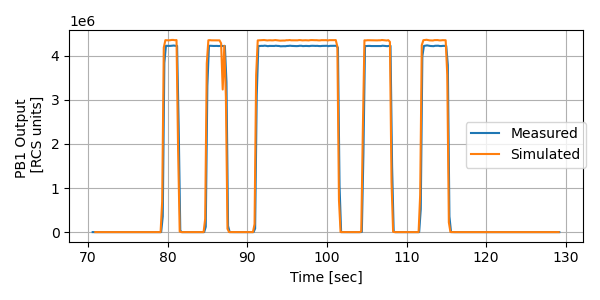

In [34]:
%matplotlib widget
fig, ax = plt.subplots(1,1, figsize=(6,3), sharex='col', sharey=False)

ax.plot(data_meas.loc[~np.isnan(data_meas.pb1), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.pb1), 'pb1'], label='Measured')
ax.plot(data_sim.loc[~np.isnan(data_sim.pb1), 'timestamp'], 
           data_sim.loc[~np.isnan(data_sim.pb1), 'pb1'], label='Simulated')
ax.legend(bbox_to_anchor=(1.02, 0.6))

ax.grid()
ax.set_xlabel('Time [sec]')
ax.set_ylabel('PB1 Output \n [RCS units]')

plt.tight_layout()

### PB --> LD --> state

In [35]:
data_sim['ld1_iso'] = np.nan*np.ones(np.shape(data_sim['td1']))
data_sim['state_iso'] = np.nan*np.ones(np.shape(data_sim['td1']))
data_sim['stim_iso'] = np.nan*np.ones(np.shape(data_sim['td1']))

# Compute continuous-valued LD output
ld_output, t_ld, update_tbl = rcs.pb_to_ld(
                                        data_meas.loc[~np.isnan(data_meas['pb1']), 
                                                      ['pb1']].values, 
                                        data_meas.loc[~np.isnan(data_meas['pb1']), 
                                                      'timestamp'].values, 
                                        update_rate=settings.update_rate[0], 
                                        weights=settings.weights[0],
                                        subtract_vec=settings.subtract_vec[0], 
                                        multiply_vec=settings.multiply_vec[0])

# Compute the state changes
state, t_state, ld_output = rcs.ld_to_state(ld_output, update_tbl, 
                                   data_meas.loc[~np.isnan(data_meas['pb1']), 
                                                 'timestamp'].values, 
                                   update_rate=settings.update_rate[0], 
                                   dual_threshold=settings.dual_threshold[0], 
                                   threshold=settings.threshold[0], 
                                   onset_duration=settings.onset[0], 
                                   termination_duration=settings.termination[0], 
                                   blank_duration=settings.blank_duration[0])

# Log the simulated data
ld1_sample_mask = np.isin(data_sim.timestamp.values, t_ld[0])
data_sim.loc[ld1_sample_mask,'ld1_iso'] = ld_output[0]

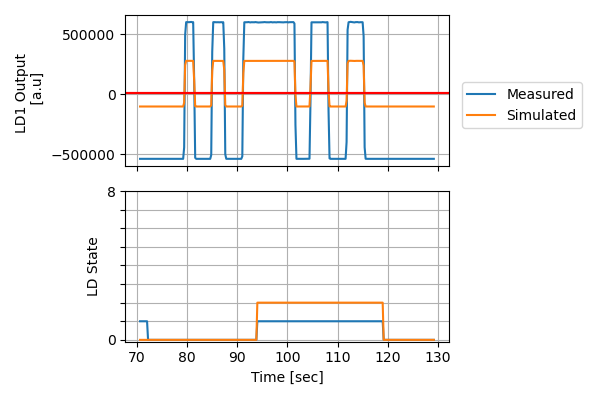

In [36]:
# %matplotlib widget
fig, ax = plt.subplots(2,1, figsize=(6,4), sharex='col', sharey=False)

ax[0].plot(data_meas.loc[~np.isnan(data_meas.ld1), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.ld1), 'ld1'], label='Measured')
ax[0].plot(data_sim.loc[~np.isnan(data_sim.ld1_iso), 'timestamp'], 
           data_sim.loc[~np.isnan(data_sim.ld1_iso), 'ld1_iso'], 
           label='Simulated')
ax[0].axhline(settings.threshold[0][0][0], color='r')
ax[0].axhline(settings.threshold[0][0][1], color='r')
ax[0].legend(bbox_to_anchor=(1.02, 0.6))

ax[1].plot(data_meas.loc[~np.isnan(data_meas.state), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.state), 'state'], label='Measured')
# ax[2].plot(data_sim.loc[~np.isnan(data_sim.state_iso), 'timestamp'], 
#            data_sim.loc[~np.isnan(data_sim.state_iso), 'state_iso'], 
#            label='Simulated')
ax[1].plot(t_state, state, 
           label='Simulated')
ax[1].set_yticks(np.arange(9))
ax[1].set_yticklabels(['0'] + ['']*7 + ['8'])

for i in range(2):
    ax[i].grid()
ax[1].set_xlabel('Time [sec]')
ax[0].set_ylabel('LD1 Output \n [a.u]')
ax[1].set_ylabel('LD State')

plt.tight_layout()

# LD4a

### Load measured datasets and settings

In [43]:
# left_neural_data = pd.read_csv(left_file_name)
data_meas = pd.read_csv(data_folder + '/dataset_ld4a.csv')
settings = pd.read_csv(data_folder + '/dataset_ld4_config.csv')
amp_gains = np.genfromtxt(data_folder + '/amp_gains.csv', 
                          delimiter=',').astype(int)

In [44]:
print('Measured data')
data_meas.head(2)

Measured data


,timestamp,td1,td2,pb1,pb2,ld1,ld2,state
0,0.000,-0.278833,-0.115073,NaN,NaN,NaN,NaN,NaN
1,0.002,-0.245248,-0.142295,NaN,NaN,NaN,NaN,NaN


In [45]:
print('Settings')
settings

Settings


,fs_td,fft_size,interval,bit_shift,band_edges_hz,subtract_vec,multiply_vec,update_rate,weights,threshold,blank_duration,onset,termination,blank_both
0,500,256,200,3,"[[28.32, 30.27], [28.32, 30.27]]","[[1120000, 590000], [1120000, 590000]]","[[0.09, 0.2], [0.09, 0.2]]","[1,1]","[[1,0], [0,1]]","[[10000, 10001], [10000, 10001]]","[15,20]","[0,0]","[0,0]","[1,1]"


In [46]:
settings['band_edges_hz'] = settings['band_edges_hz'].apply(literal_eval)
settings['subtract_vec'] = settings['subtract_vec'].apply(literal_eval)
settings['multiply_vec'] = settings['multiply_vec'].apply(literal_eval)
settings['update_rate'] = settings['update_rate'].apply(literal_eval)
settings['weights'] = settings['weights'].apply(literal_eval)
settings['dual_threshold'] = [[True, True]] #settings['dual_threshold'].apply(literal_eval)
settings['threshold'] = settings['threshold'].apply(literal_eval)
settings['blank_duration'] = settings['blank_duration'].apply(literal_eval)
settings['onset'] = settings['onset'].apply(literal_eval)
settings['termination'] = settings['termination'].apply(literal_eval)
settings['blank_both'] = settings['blank_both'] #.apply(literal_eval)
# settings['target_amp'] = settings['target_amp'].apply(literal_eval)

In [47]:
print('Settings')
settings

Settings


,fs_td,fft_size,interval,bit_shift,band_edges_hz,subtract_vec,multiply_vec,update_rate,weights,threshold,blank_duration,onset,termination,blank_both,dual_threshold
0,500,256,200,3,"[[28.32, 30.27], [28.32, 30.27]]","[[1120000, 590000], [1120000, 590000]]","[[0.09, 0.2], [0.09, 0.2]]","[1, 1]","[[1, 0], [0, 1]]","[[10000, 10001], [10000, 10001]]","[15, 20]","[0, 0]","[0, 0]","[1,1]","[True, True]"


### TD --> PB

In [48]:
data_sim = data_meas[['timestamp', 'td1', 'td2']].copy()
data_sim['pb1'] = np.nan*np.ones(np.shape(data_sim['td1']))
data_sim['pb2'] = np.nan*np.ones(np.shape(data_sim['td1']))

t_start = time.time()
hann_win = rcs.create_hann_window(settings.fft_size[0], percent=100)

# Compute power band for the first time-domain channel
data_td = rcs.transform_mv_to_rcs(data_sim['td1'].values, amp_gains[0])
data_fft, t_pb = rcs.td_to_fft(data_td, 
                               data_sim['timestamp'].values, settings.fs_td[0], 
                               settings.fft_size[0], settings.interval[0], 
                               hann_win, output_in_mv=False)
data_pb = rcs.fft_to_pb(data_fft, settings.fs_td[0], settings.fft_size[0], 
                        settings.bit_shift[0], 
                        band_edges_hz=settings.band_edges_hz[0][0], 
                        input_is_mv=False)
pb_sample_mask = np.isin(data_sim.timestamp, t_pb)
data_sim.loc[pb_sample_mask,'pb1'] = data_pb

# Compute power band for the second time-domain channel
data_td = rcs.transform_mv_to_rcs(data_sim['td2'].values, amp_gains[1])
data_fft, t_pb = rcs.td_to_fft(data_td, 
                               data_sim['timestamp'].values, settings.fs_td[0], 
                               settings.fft_size[0], settings.interval[0], 
                               hann_win, output_in_mv=False)
data_pb = rcs.fft_to_pb(data_fft, settings.fs_td[0], settings.fft_size[0], 
                        settings.bit_shift[0], 
                        band_edges_hz=settings.band_edges_hz[0][1], 
                        input_is_mv=False)
pb_sample_mask = np.isin(data_sim.timestamp, t_pb)
data_sim.loc[pb_sample_mask,'pb2'] = data_pb

t_end = time.time()
print('Time elapsed: ' + str(t_end-t_start))

Time elapsed: 0.026074886322021484


In [49]:
data_meas.head(2)

,timestamp,td1,td2,pb1,pb2,ld1,ld2,state
0,0.000,-0.278833,-0.115073,NaN,NaN,NaN,NaN,NaN
1,0.002,-0.245248,-0.142295,NaN,NaN,NaN,NaN,NaN


In [50]:
data_sim.head(2)

,timestamp,td1,td2,pb1,pb2
0,0.000,-0.278833,-0.115073,NaN,NaN
1,0.002,-0.245248,-0.142295,NaN,NaN


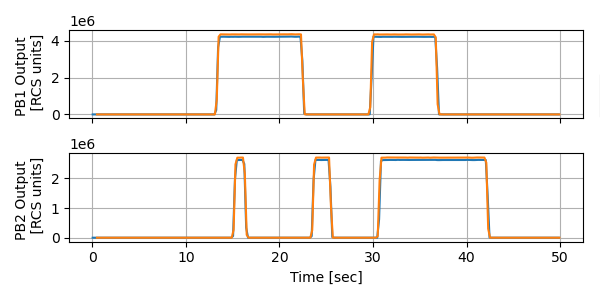

In [51]:
%matplotlib widget
fig, ax = plt.subplots(2,1, figsize=(6,3), sharex='col', sharey=False)

ax[0].plot(data_meas.loc[~np.isnan(data_meas.pb1), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.pb1), 'pb1'], label='Measured')
ax[0].plot(data_sim.loc[~np.isnan(data_sim.pb1), 'timestamp'], 
           data_sim.loc[~np.isnan(data_sim.pb1), 'pb1'], label='Simulated')
ax[0].legend(bbox_to_anchor=(1.02, 0.6))

ax[1].plot(data_meas.loc[~np.isnan(data_meas.pb1), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.pb1), 'pb2'], label='Measured')
ax[1].plot(data_sim.loc[~np.isnan(data_sim.pb1), 'timestamp'], 
           data_sim.loc[~np.isnan(data_sim.pb1), 'pb2'], label='Simulated')

ax[0].grid()
ax[1].grid()
ax[1].set_xlabel('Time [sec]')
ax[0].set_ylabel('PB1 Output \n [RCS units]')
ax[1].set_ylabel('PB2 Output \n [RCS units]')

plt.tight_layout()

### PB --> LD --> state

In [53]:
data_sim['ld1_iso'] = np.nan*np.ones(np.shape(data_sim['td1']))
data_sim['ld2_iso'] = np.nan*np.ones(np.shape(data_sim['td1']))
data_sim['state_iso'] = np.nan*np.ones(np.shape(data_sim['td1']))
data_sim['stim_iso'] = np.nan*np.ones(np.shape(data_sim['td1']))

# Compute continuous-valued LD output
ld_output, t_ld, update_tbl = rcs.pb_to_ld(
                                        data_meas.loc[~np.isnan(data_meas['pb1']), 
                                                      ['pb1', 'pb2']].values, 
                                        data_meas.loc[~np.isnan(data_meas['pb1']), 
                                                      'timestamp'].values, 
                                        update_rate=settings.update_rate[0], 
                                        weights=settings.weights[0],
                                        subtract_vec=settings.subtract_vec[0], 
                                        multiply_vec=settings.multiply_vec[0])

# Compute the state changes
state, t_state, ld_output = rcs.ld_to_state(ld_output, update_tbl, 
                                   data_meas.loc[~np.isnan(data_meas['pb1']), 
                                                 'timestamp'].values, 
                                   update_rate=settings.update_rate[0], 
                                   dual_threshold=settings.dual_threshold[0], 
                                   threshold=settings.threshold[0], 
                                   onset_duration=settings.onset[0], 
                                   termination_duration=settings.termination[0], 
                                   blank_duration=settings.blank_duration[0])

# Log the simulated data
ld1_sample_mask = np.isin(data_sim.timestamp.values, t_ld[0])
data_sim.loc[ld1_sample_mask,'ld1_iso'] = ld_output[0]

ld2_sample_mask = np.isin(data_sim.timestamp.values, t_ld[1])
data_sim.loc[ld2_sample_mask,'ld2_iso'] = ld_output[1]

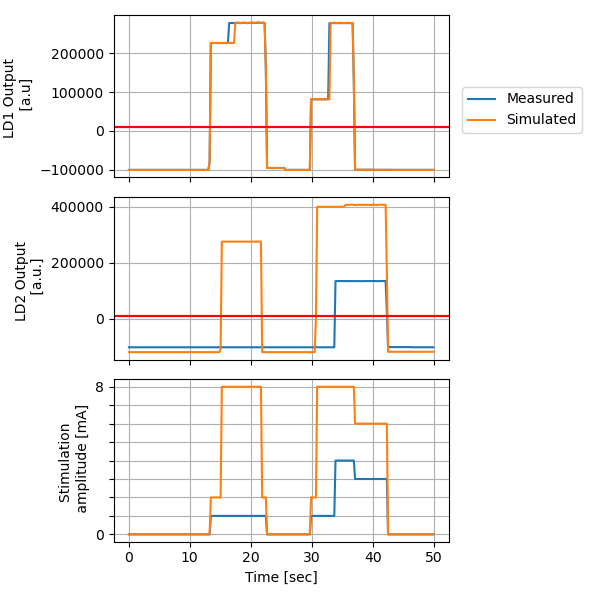

In [54]:
# %matplotlib widget
fig, ax = plt.subplots(3,1, figsize=(6,6), sharex='col', sharey=False)

ax[0].plot(data_meas.loc[~np.isnan(data_meas.ld1), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.ld1), 'ld1'], label='Measured')
ax[0].plot(data_sim.loc[~np.isnan(data_sim.ld1_iso), 'timestamp'], 
           data_sim.loc[~np.isnan(data_sim.ld1_iso), 'ld1_iso'], 
           label='Simulated')
ax[0].axhline(settings.threshold[0][0][0], color='r')
ax[0].axhline(settings.threshold[0][0][1], color='r')
ax[0].legend(bbox_to_anchor=(1.02, 0.6))

ax[1].plot(data_meas.loc[~np.isnan(data_meas.ld2), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.ld2), 'ld2'], label='Measured')
ax[1].plot(data_sim.loc[~np.isnan(data_sim.ld2_iso), 'timestamp'], 
           data_sim.loc[~np.isnan(data_sim.ld2_iso), 'ld2_iso'], 
           label='Simulated')
ax[1].axhline(settings.threshold[0][1][0], color='r')
ax[1].axhline(settings.threshold[0][1][1], color='r')

ax[2].plot(data_meas.loc[~np.isnan(data_meas.state), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.state), 'state'], label='Measured')
# ax[2].plot(data_sim.loc[~np.isnan(data_sim.state_iso), 'timestamp'], 
#            data_sim.loc[~np.isnan(data_sim.state_iso), 'state_iso'], 
#            label='Simulated')
ax[2].plot(t_state, state, 
           label='Simulated')
ax[2].set_yticks(np.arange(9))
ax[2].set_yticklabels(['0'] + ['']*7 + ['8'])

for i in range(3):
    ax[i].grid()
ax[2].set_xlabel('Time [sec]')
ax[0].set_ylabel('LD1 Output \n [a.u]')
ax[1].set_ylabel('LD2 Output \n [a.u.]')
ax[2].set_ylabel('LD State')
ax[2].set_ylabel('Stimulation \n amplitude [mA]')

plt.tight_layout()

In [63]:
os.chdir('/media/shortterm_ssd/dlawrence/rclone/rcssim_testing/csv')

In [64]:
amp_gains = pd.read_csv('amp_gains.csv')

# LD4b

### Load measured datasets and settings

In [55]:
# left_neural_data = pd.read_csv(left_file_name)
data_meas = pd.read_csv(data_folder + '/dataset_ld4b.csv')
settings = pd.read_csv(data_folder + '/dataset_ld4_config.csv')
amp_gains = np.genfromtxt(data_folder + '/amp_gains.csv', 
                          delimiter=',').astype(int)

In [56]:
print('Measured data')
data_meas.head(2)

Measured data


,timestamp,td1,td2,pb1,pb2,ld1,ld2,state
0,0.000,-0.227646,-0.153792,NaN,NaN,NaN,NaN,NaN
1,0.002,-0.199460,-0.173422,NaN,NaN,NaN,NaN,NaN


In [57]:
print('Settings')
settings

Settings


,fs_td,fft_size,interval,bit_shift,band_edges_hz,subtract_vec,multiply_vec,update_rate,weights,threshold,blank_duration,onset,termination,blank_both
0,500,256,200,3,"[[28.32, 30.27], [28.32, 30.27]]","[[1120000, 590000], [1120000, 590000]]","[[0.09, 0.2], [0.09, 0.2]]","[1,1]","[[1,0], [0,1]]","[[10000, 10001], [10000, 10001]]","[15,20]","[0,0]","[0,0]","[1,1]"


In [58]:
settings['band_edges_hz'] = settings['band_edges_hz'].apply(literal_eval)
settings['subtract_vec'] = settings['subtract_vec'].apply(literal_eval)
settings['multiply_vec'] = settings['multiply_vec'].apply(literal_eval)
settings['update_rate'] = settings['update_rate'].apply(literal_eval)
settings['weights'] = settings['weights'].apply(literal_eval)
settings['dual_threshold'] = [[True, True]] #settings['dual_threshold'].apply(literal_eval)
settings['threshold'] = settings['threshold'].apply(literal_eval)
settings['blank_duration'] = settings['blank_duration'].apply(literal_eval)
settings['onset'] = settings['onset'].apply(literal_eval)
settings['termination'] = settings['termination'].apply(literal_eval)
settings['blank_both'] = settings['blank_both'] #.apply(literal_eval)
# settings['target_amp'] = settings['target_amp'].apply(literal_eval)

In [59]:
print('Settings')
settings

Settings


,fs_td,fft_size,interval,bit_shift,band_edges_hz,subtract_vec,multiply_vec,update_rate,weights,threshold,blank_duration,onset,termination,blank_both,dual_threshold
0,500,256,200,3,"[[28.32, 30.27], [28.32, 30.27]]","[[1120000, 590000], [1120000, 590000]]","[[0.09, 0.2], [0.09, 0.2]]","[1, 1]","[[1, 0], [0, 1]]","[[10000, 10001], [10000, 10001]]","[15, 20]","[0, 0]","[0, 0]","[1,1]","[True, True]"


### TD --> PB

In [60]:
data_sim = data_meas[['timestamp', 'td1', 'td2']].copy()
data_sim['pb1'] = np.nan*np.ones(np.shape(data_sim['td1']))
data_sim['pb2'] = np.nan*np.ones(np.shape(data_sim['td1']))

t_start = time.time()
hann_win = rcs.create_hann_window(settings.fft_size[0], percent=100)

# Compute power band for the first time-domain channel
data_td = rcs.transform_mv_to_rcs(data_sim['td1'].values, amp_gains[0])
data_fft, t_pb = rcs.td_to_fft(data_td, 
                               data_sim['timestamp'].values, settings.fs_td[0], 
                               settings.fft_size[0], settings.interval[0], 
                               hann_win, output_in_mv=False)
data_pb = rcs.fft_to_pb(data_fft, settings.fs_td[0], settings.fft_size[0], 
                        settings.bit_shift[0], 
                        band_edges_hz=settings.band_edges_hz[0][0], 
                        input_is_mv=False)
pb_sample_mask = np.isin(data_sim.timestamp, t_pb)
data_sim.loc[pb_sample_mask,'pb1'] = data_pb

# Compute power band for the second time-domain channel
data_td = rcs.transform_mv_to_rcs(data_sim['td2'].values, amp_gains[1])
data_fft, t_pb = rcs.td_to_fft(data_td, 
                               data_sim['timestamp'].values, settings.fs_td[0], 
                               settings.fft_size[0], settings.interval[0], 
                               hann_win, output_in_mv=False)
data_pb = rcs.fft_to_pb(data_fft, settings.fs_td[0], settings.fft_size[0], 
                        settings.bit_shift[0], 
                        band_edges_hz=settings.band_edges_hz[0][1], 
                        input_is_mv=False)
pb_sample_mask = np.isin(data_sim.timestamp, t_pb)
data_sim.loc[pb_sample_mask,'pb2'] = data_pb

t_end = time.time()
print('Time elapsed: ' + str(t_end-t_start))

Time elapsed: 0.019430160522460938


In [61]:
data_meas.head(2)

,timestamp,td1,td2,pb1,pb2,ld1,ld2,state
0,0.000,-0.227646,-0.153792,NaN,NaN,NaN,NaN,NaN
1,0.002,-0.199460,-0.173422,NaN,NaN,NaN,NaN,NaN


In [62]:
data_sim.head(2)

,timestamp,td1,td2,pb1,pb2
0,0.000,-0.227646,-0.153792,NaN,NaN
1,0.002,-0.199460,-0.173422,NaN,NaN


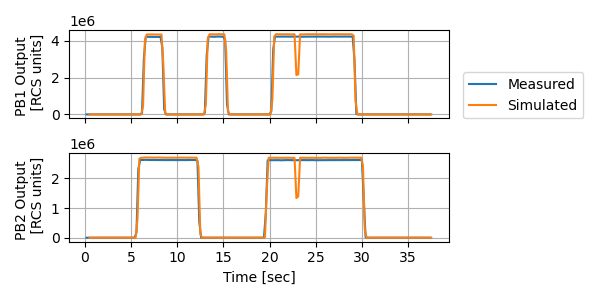

In [63]:
%matplotlib widget
fig, ax = plt.subplots(2,1, figsize=(6,3), sharex='col', sharey=False)

ax[0].plot(data_meas.loc[~np.isnan(data_meas.pb1), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.pb1), 'pb1'], label='Measured')
ax[0].plot(data_sim.loc[~np.isnan(data_sim.pb1), 'timestamp'], 
           data_sim.loc[~np.isnan(data_sim.pb1), 'pb1'], label='Simulated')
ax[0].legend(bbox_to_anchor=(1.02, 0.6))

ax[1].plot(data_meas.loc[~np.isnan(data_meas.pb1), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.pb1), 'pb2'], label='Measured')
ax[1].plot(data_sim.loc[~np.isnan(data_sim.pb1), 'timestamp'], 
           data_sim.loc[~np.isnan(data_sim.pb1), 'pb2'], label='Simulated')

ax[0].grid()
ax[1].grid()
ax[1].set_xlabel('Time [sec]')
ax[0].set_ylabel('PB1 Output \n [RCS units]')
ax[1].set_ylabel('PB2 Output \n [RCS units]')

plt.tight_layout()

### PB --> LD --> state

In [64]:
data_sim['ld1_iso'] = np.nan*np.ones(np.shape(data_sim['td1']))
data_sim['ld2_iso'] = np.nan*np.ones(np.shape(data_sim['td1']))
data_sim['state_iso'] = np.nan*np.ones(np.shape(data_sim['td1']))
data_sim['stim_iso'] = np.nan*np.ones(np.shape(data_sim['td1']))

# Compute continuous-valued LD output
ld_output, t_ld, update_tbl = rcs.pb_to_ld(
                                        data_meas.loc[~np.isnan(data_meas['pb1']), 
                                                      ['pb1', 'pb2']].values, 
                                        data_meas.loc[~np.isnan(data_meas['pb1']), 
                                                      'timestamp'].values, 
                                        update_rate=settings.update_rate[0], 
                                        weights=settings.weights[0],
                                        subtract_vec=settings.subtract_vec[0], 
                                        multiply_vec=settings.multiply_vec[0])

# Compute the state changes
state, t_state, ld_output = rcs.ld_to_state(ld_output, update_tbl, 
                                   data_meas.loc[~np.isnan(data_meas['pb1']), 
                                                 'timestamp'].values, 
                                   update_rate=settings.update_rate[0], 
                                   dual_threshold=settings.dual_threshold[0], 
                                   threshold=settings.threshold[0], 
                                   onset_duration=settings.onset[0], 
                                   termination_duration=settings.termination[0], 
                                   blank_duration=settings.blank_duration[0])

# Log the simulated data
ld1_sample_mask = np.isin(data_sim.timestamp.values, t_ld[0])
data_sim.loc[ld1_sample_mask,'ld1_iso'] = ld_output[0]

ld2_sample_mask = np.isin(data_sim.timestamp.values, t_ld[1])
data_sim.loc[ld2_sample_mask,'ld2_iso'] = ld_output[1]

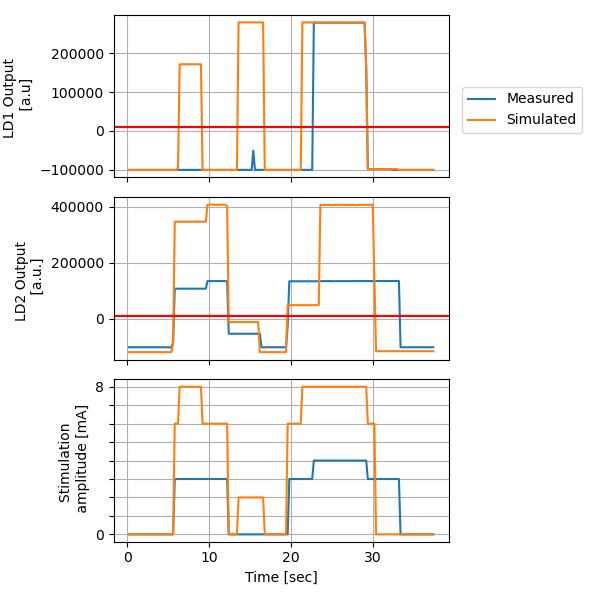

In [65]:
# %matplotlib widget
fig, ax = plt.subplots(3,1, figsize=(6,6), sharex='col', sharey=False)

ax[0].plot(data_meas.loc[~np.isnan(data_meas.ld1), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.ld1), 'ld1'], label='Measured')
ax[0].plot(data_sim.loc[~np.isnan(data_sim.ld1_iso), 'timestamp'], 
           data_sim.loc[~np.isnan(data_sim.ld1_iso), 'ld1_iso'], 
           label='Simulated')
ax[0].axhline(settings.threshold[0][0][0], color='r')
ax[0].axhline(settings.threshold[0][0][1], color='r')
ax[0].legend(bbox_to_anchor=(1.02, 0.6))

ax[1].plot(data_meas.loc[~np.isnan(data_meas.ld2), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.ld2), 'ld2'], label='Measured')
ax[1].plot(data_sim.loc[~np.isnan(data_sim.ld2_iso), 'timestamp'], 
           data_sim.loc[~np.isnan(data_sim.ld2_iso), 'ld2_iso'], 
           label='Simulated')
ax[1].axhline(settings.threshold[0][1][0], color='r')
ax[1].axhline(settings.threshold[0][1][1], color='r')

ax[2].plot(data_meas.loc[~np.isnan(data_meas.state), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.state), 'state'], label='Measured')
# ax[2].plot(data_sim.loc[~np.isnan(data_sim.state_iso), 'timestamp'], 
#            data_sim.loc[~np.isnan(data_sim.state_iso), 'state_iso'], 
#            label='Simulated')
ax[2].plot(t_state, state, 
           label='Simulated')
ax[2].set_yticks(np.arange(9))
ax[2].set_yticklabels(['0'] + ['']*7 + ['8'])

for i in range(3):
    ax[i].grid()
ax[2].set_xlabel('Time [sec]')
ax[0].set_ylabel('LD1 Output \n [a.u]')
ax[1].set_ylabel('LD2 Output \n [a.u.]')
ax[2].set_ylabel('LD State')
ax[2].set_ylabel('Stimulation \n amplitude [mA]')

plt.tight_layout()

# LD4c

### Load measured datasets and settings

In [67]:
# left_neural_data = pd.read_csv(left_file_name)
data_meas = pd.read_csv(data_folder + '/dataset_ld4c.csv')
settings = pd.read_csv(data_folder + '/dataset_ld4_config.csv')
amp_gains = np.genfromtxt(data_folder + '/amp_gains.csv', 
                          delimiter=',').astype(int)

In [68]:
print('Measured data')
data_meas.head(2)

Measured data


,timestamp,td1,td2,pb1,pb2,ld1,ld2,state
0,0.000,-0.206695,-0.172772,NaN,NaN,NaN,NaN,NaN
1,0.002,-0.227969,-0.154009,NaN,NaN,NaN,NaN,NaN


In [69]:
print('Settings')
settings

Settings


,fs_td,fft_size,interval,bit_shift,band_edges_hz,subtract_vec,multiply_vec,update_rate,weights,threshold,blank_duration,onset,termination,blank_both
0,500,256,200,3,"[[28.32, 30.27], [28.32, 30.27]]","[[1120000, 590000], [1120000, 590000]]","[[0.09, 0.2], [0.09, 0.2]]","[1,1]","[[1,0], [0,1]]","[[10000, 10001], [10000, 10001]]","[15,20]","[0,0]","[0,0]","[1,1]"


In [70]:
settings['band_edges_hz'] = settings['band_edges_hz'].apply(literal_eval)
settings['subtract_vec'] = settings['subtract_vec'].apply(literal_eval)
settings['multiply_vec'] = settings['multiply_vec'].apply(literal_eval)
settings['update_rate'] = settings['update_rate'].apply(literal_eval)
settings['weights'] = settings['weights'].apply(literal_eval)
settings['dual_threshold'] = [[True, True]] #settings['dual_threshold'].apply(literal_eval)
settings['threshold'] = settings['threshold'].apply(literal_eval)
settings['blank_duration'] = settings['blank_duration'].apply(literal_eval)
settings['onset'] = settings['onset'].apply(literal_eval)
settings['termination'] = settings['termination'].apply(literal_eval)
settings['blank_both'] = settings['blank_both'] #.apply(literal_eval)
# settings['target_amp'] = settings['target_amp'].apply(literal_eval)

In [71]:
print('Settings')
settings

Settings


,fs_td,fft_size,interval,bit_shift,band_edges_hz,subtract_vec,multiply_vec,update_rate,weights,threshold,blank_duration,onset,termination,blank_both,dual_threshold
0,500,256,200,3,"[[28.32, 30.27], [28.32, 30.27]]","[[1120000, 590000], [1120000, 590000]]","[[0.09, 0.2], [0.09, 0.2]]","[1, 1]","[[1, 0], [0, 1]]","[[10000, 10001], [10000, 10001]]","[15, 20]","[0, 0]","[0, 0]","[1,1]","[True, True]"


### TD --> PB

In [72]:
data_sim = data_meas[['timestamp', 'td1', 'td2']].copy()
data_sim['pb1'] = np.nan*np.ones(np.shape(data_sim['td1']))
data_sim['pb2'] = np.nan*np.ones(np.shape(data_sim['td1']))

t_start = time.time()
hann_win = rcs.create_hann_window(settings.fft_size[0], percent=100)

# Compute power band for the first time-domain channel
data_td = rcs.transform_mv_to_rcs(data_sim['td1'].values, amp_gains[0])
data_fft, t_pb = rcs.td_to_fft(data_td, 
                               data_sim['timestamp'].values, settings.fs_td[0], 
                               settings.fft_size[0], settings.interval[0], 
                               hann_win, output_in_mv=False)
data_pb = rcs.fft_to_pb(data_fft, settings.fs_td[0], settings.fft_size[0], 
                        settings.bit_shift[0], 
                        band_edges_hz=settings.band_edges_hz[0][0], 
                        input_is_mv=False)
pb_sample_mask = np.isin(data_sim.timestamp, t_pb)
data_sim.loc[pb_sample_mask,'pb1'] = data_pb

# Compute power band for the second time-domain channel
data_td = rcs.transform_mv_to_rcs(data_sim['td2'].values, amp_gains[1])
data_fft, t_pb = rcs.td_to_fft(data_td, 
                               data_sim['timestamp'].values, settings.fs_td[0], 
                               settings.fft_size[0], settings.interval[0], 
                               hann_win, output_in_mv=False)
data_pb = rcs.fft_to_pb(data_fft, settings.fs_td[0], settings.fft_size[0], 
                        settings.bit_shift[0], 
                        band_edges_hz=settings.band_edges_hz[0][1], 
                        input_is_mv=False)
pb_sample_mask = np.isin(data_sim.timestamp, t_pb)
data_sim.loc[pb_sample_mask,'pb2'] = data_pb

t_end = time.time()
print('Time elapsed: ' + str(t_end-t_start))

Time elapsed: 0.03542971611022949


In [73]:
data_meas.head(2)

,timestamp,td1,td2,pb1,pb2,ld1,ld2,state
0,0.000,-0.206695,-0.172772,NaN,NaN,NaN,NaN,NaN
1,0.002,-0.227969,-0.154009,NaN,NaN,NaN,NaN,NaN


In [74]:
data_sim.head(2)

,timestamp,td1,td2,pb1,pb2
0,0.000,-0.206695,-0.172772,NaN,NaN
1,0.002,-0.227969,-0.154009,NaN,NaN


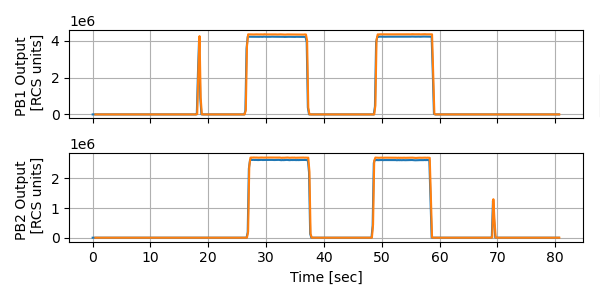

In [75]:
%matplotlib widget
fig, ax = plt.subplots(2,1, figsize=(6,3), sharex='col', sharey=False)

ax[0].plot(data_meas.loc[~np.isnan(data_meas.pb1), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.pb1), 'pb1'], label='Measured')
ax[0].plot(data_sim.loc[~np.isnan(data_sim.pb1), 'timestamp'], 
           data_sim.loc[~np.isnan(data_sim.pb1), 'pb1'], label='Simulated')
ax[0].legend(bbox_to_anchor=(1.02, 0.6))

ax[1].plot(data_meas.loc[~np.isnan(data_meas.pb1), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.pb1), 'pb2'], label='Measured')
ax[1].plot(data_sim.loc[~np.isnan(data_sim.pb1), 'timestamp'], 
           data_sim.loc[~np.isnan(data_sim.pb1), 'pb2'], label='Simulated')

ax[0].grid()
ax[1].grid()
ax[1].set_xlabel('Time [sec]')
ax[0].set_ylabel('PB1 Output \n [RCS units]')
ax[1].set_ylabel('PB2 Output \n [RCS units]')

plt.tight_layout()

### PB --> LD --> state

In [76]:
data_sim['ld1_iso'] = np.nan*np.ones(np.shape(data_sim['td1']))
data_sim['ld2_iso'] = np.nan*np.ones(np.shape(data_sim['td1']))
data_sim['state_iso'] = np.nan*np.ones(np.shape(data_sim['td1']))
data_sim['stim_iso'] = np.nan*np.ones(np.shape(data_sim['td1']))

# Compute continuous-valued LD output
ld_output, t_ld, update_tbl = rcs.pb_to_ld(
                                        data_meas.loc[~np.isnan(data_meas['pb1']), 
                                                      ['pb1', 'pb2']].values, 
                                        data_meas.loc[~np.isnan(data_meas['pb1']), 
                                                      'timestamp'].values, 
                                        update_rate=settings.update_rate[0], 
                                        weights=settings.weights[0],
                                        subtract_vec=settings.subtract_vec[0], 
                                        multiply_vec=settings.multiply_vec[0])

# Compute the state changes
state, t_state, ld_output = rcs.ld_to_state(ld_output, update_tbl, 
                                   data_meas.loc[~np.isnan(data_meas['pb1']), 
                                                 'timestamp'].values, 
                                   update_rate=settings.update_rate[0], 
                                   dual_threshold=settings.dual_threshold[0], 
                                   threshold=settings.threshold[0], 
                                   onset_duration=settings.onset[0], 
                                   termination_duration=settings.termination[0], 
                                   blank_duration=settings.blank_duration[0])

# Log the simulated data
ld1_sample_mask = np.isin(data_sim.timestamp.values, t_ld[0])
data_sim.loc[ld1_sample_mask,'ld1_iso'] = ld_output[0]

ld2_sample_mask = np.isin(data_sim.timestamp.values, t_ld[1])
data_sim.loc[ld2_sample_mask,'ld2_iso'] = ld_output[1]

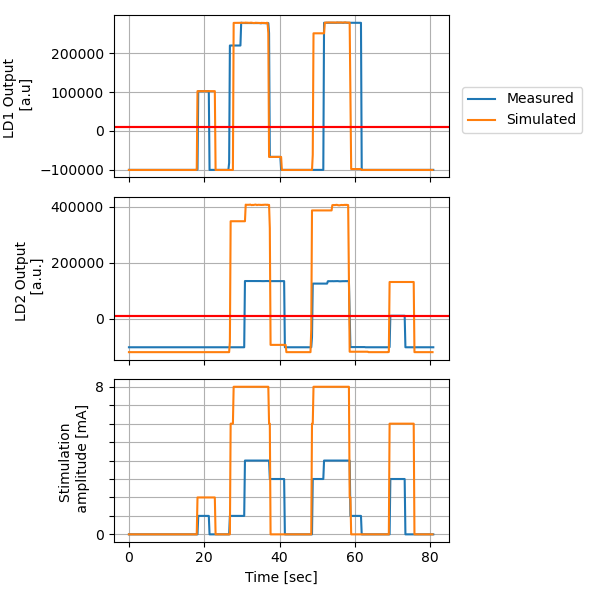

In [77]:
# %matplotlib widget
fig, ax = plt.subplots(3,1, figsize=(6,6), sharex='col', sharey=False)

ax[0].plot(data_meas.loc[~np.isnan(data_meas.ld1), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.ld1), 'ld1'], label='Measured')
ax[0].plot(data_sim.loc[~np.isnan(data_sim.ld1_iso), 'timestamp'], 
           data_sim.loc[~np.isnan(data_sim.ld1_iso), 'ld1_iso'], 
           label='Simulated')
ax[0].axhline(settings.threshold[0][0][0], color='r')
ax[0].axhline(settings.threshold[0][0][1], color='r')
ax[0].legend(bbox_to_anchor=(1.02, 0.6))

ax[1].plot(data_meas.loc[~np.isnan(data_meas.ld2), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.ld2), 'ld2'], label='Measured')
ax[1].plot(data_sim.loc[~np.isnan(data_sim.ld2_iso), 'timestamp'], 
           data_sim.loc[~np.isnan(data_sim.ld2_iso), 'ld2_iso'], 
           label='Simulated')
ax[1].axhline(settings.threshold[0][1][0], color='r')
ax[1].axhline(settings.threshold[0][1][1], color='r')

ax[2].plot(data_meas.loc[~np.isnan(data_meas.state), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.state), 'state'], label='Measured')
# ax[2].plot(data_sim.loc[~np.isnan(data_sim.state_iso), 'timestamp'], 
#            data_sim.loc[~np.isnan(data_sim.state_iso), 'state_iso'], 
#            label='Simulated')
ax[2].plot(t_state, state, 
           label='Simulated')
ax[2].set_yticks(np.arange(9))
ax[2].set_yticklabels(['0'] + ['']*7 + ['8'])

for i in range(3):
    ax[i].grid()
ax[2].set_xlabel('Time [sec]')
ax[0].set_ylabel('LD1 Output \n [a.u]')
ax[1].set_ylabel('LD2 Output \n [a.u.]')
ax[2].set_ylabel('LD State')
ax[2].set_ylabel('Stimulation \n amplitude [mA]')

plt.tight_layout()

# No ld5.csv

# LD6

### Load measured datasets and settings

In [79]:
# left_neural_data = pd.read_csv(left_file_name)
data_meas = pd.read_csv(data_folder + '/dataset_ld6.csv')
settings = pd.read_csv(data_folder + '/dataset_ld6_config.csv')
amp_gains = np.genfromtxt(data_folder + '/amp_gains.csv', 
                          delimiter=',').astype(int)

In [80]:
print('Measured data')
data_meas.head(2)

Measured data


,timestamp,td1,td2,pb1,pb2,ld1,ld2,state
0,0.000,-0.409935,-0.164095,NaN,NaN,NaN,NaN,NaN
1,0.002,-0.403995,-0.099346,NaN,NaN,NaN,NaN,NaN


In [81]:
print('Settings')
settings

Settings


,fs_td,fft_size,interval,bit_shift,band_edges_hz,subtract_vec,multiply_vec,update_rate,weights,threshold,blank_duration,onset,termination,blank_both
0,500,256,200,3,"[[28.32, 30.27], [28.32, 30.27]]","[[1120000], [590000]]","[[0.09], [0.2]]","[1,1]","[[1], [1]]","[[10000, 100000], [10000, 100000]]","[0,0]","[0,0]","[0,0]","[1,1]"


In [82]:
settings['band_edges_hz'] = settings['band_edges_hz'].apply(literal_eval)
settings['subtract_vec'] = settings['subtract_vec'].apply(literal_eval)
settings['multiply_vec'] = settings['multiply_vec'].apply(literal_eval)
settings['update_rate'] = settings['update_rate'].apply(literal_eval)
settings['weights'] = settings['weights'].apply(literal_eval)
settings['dual_threshold'] = [[True, True]] #settings['dual_threshold'].apply(literal_eval)
settings['threshold'] = settings['threshold'].apply(literal_eval)
settings['blank_duration'] = settings['blank_duration'].apply(literal_eval)
settings['onset'] = settings['onset'].apply(literal_eval)
settings['termination'] = settings['termination'].apply(literal_eval)
settings['blank_both'] = settings['blank_both'] #.apply(literal_eval)
# settings['target_amp'] = settings['target_amp'].apply(literal_eval)

In [83]:
print('Settings')
settings

Settings


,fs_td,fft_size,interval,bit_shift,band_edges_hz,subtract_vec,multiply_vec,update_rate,weights,threshold,blank_duration,onset,termination,blank_both,dual_threshold
0,500,256,200,3,"[[28.32, 30.27], [28.32, 30.27]]","[[1120000], [590000]]","[[0.09], [0.2]]","[1, 1]","[[1], [1]]","[[10000, 100000], [10000, 100000]]","[0, 0]","[0, 0]","[0, 0]","[1,1]","[True, True]"


### TD --> PB

In [84]:
data_sim = data_meas[['timestamp', 'td1', 'td2']].copy()
data_sim['pb1'] = np.nan*np.ones(np.shape(data_sim['td1']))
data_sim['pb2'] = np.nan*np.ones(np.shape(data_sim['td1']))

t_start = time.time()
hann_win = rcs.create_hann_window(settings.fft_size[0], percent=100)

# Compute power band for the first time-domain channel
data_td = rcs.transform_mv_to_rcs(data_sim['td1'].values, amp_gains[0])
data_fft, t_pb = rcs.td_to_fft(data_td, 
                               data_sim['timestamp'].values, settings.fs_td[0], 
                               settings.fft_size[0], settings.interval[0], 
                               hann_win, output_in_mv=False)
data_pb = rcs.fft_to_pb(data_fft, settings.fs_td[0], settings.fft_size[0], 
                        settings.bit_shift[0], 
                        band_edges_hz=settings.band_edges_hz[0][0], 
                        input_is_mv=False)
pb_sample_mask = np.isin(data_sim.timestamp, t_pb)
data_sim.loc[pb_sample_mask,'pb1'] = data_pb

# Compute power band for the second time-domain channel
data_td = rcs.transform_mv_to_rcs(data_sim['td2'].values, amp_gains[1])
data_fft, t_pb = rcs.td_to_fft(data_td, 
                               data_sim['timestamp'].values, settings.fs_td[0], 
                               settings.fft_size[0], settings.interval[0], 
                               hann_win, output_in_mv=False)
data_pb = rcs.fft_to_pb(data_fft, settings.fs_td[0], settings.fft_size[0], 
                        settings.bit_shift[0], 
                        band_edges_hz=settings.band_edges_hz[0][1], 
                        input_is_mv=False)
pb_sample_mask = np.isin(data_sim.timestamp, t_pb)
data_sim.loc[pb_sample_mask,'pb2'] = data_pb

t_end = time.time()
print('Time elapsed: ' + str(t_end-t_start))

Time elapsed: 0.06250166893005371


In [85]:
data_meas.head(2)

,timestamp,td1,td2,pb1,pb2,ld1,ld2,state
0,0.000,-0.409935,-0.164095,NaN,NaN,NaN,NaN,NaN
1,0.002,-0.403995,-0.099346,NaN,NaN,NaN,NaN,NaN


In [86]:
data_sim.head(2)

,timestamp,td1,td2,pb1,pb2
0,0.000,-0.409935,-0.164095,NaN,NaN
1,0.002,-0.403995,-0.099346,NaN,NaN


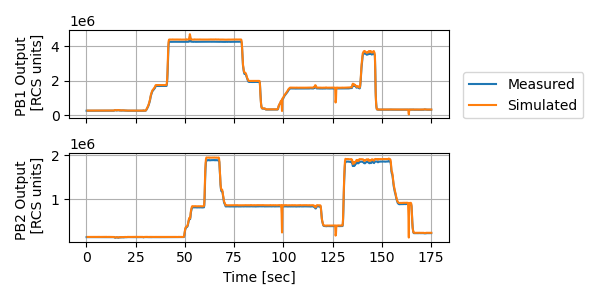

In [87]:
%matplotlib widget
fig, ax = plt.subplots(2,1, figsize=(6,3), sharex='col', sharey=False)

ax[0].plot(data_meas.loc[~np.isnan(data_meas.pb1), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.pb1), 'pb1'], label='Measured')
ax[0].plot(data_sim.loc[~np.isnan(data_sim.pb1), 'timestamp'], 
           data_sim.loc[~np.isnan(data_sim.pb1), 'pb1'], label='Simulated')
ax[0].legend(bbox_to_anchor=(1.02, 0.6))

ax[1].plot(data_meas.loc[~np.isnan(data_meas.pb1), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.pb1), 'pb2'], label='Measured')
ax[1].plot(data_sim.loc[~np.isnan(data_sim.pb1), 'timestamp'], 
           data_sim.loc[~np.isnan(data_sim.pb1), 'pb2'], label='Simulated')

ax[0].grid()
ax[1].grid()
ax[1].set_xlabel('Time [sec]')
ax[0].set_ylabel('PB1 Output \n [RCS units]')
ax[1].set_ylabel('PB2 Output \n [RCS units]')

plt.tight_layout()

### PB --> LD --> state

In [88]:
data_sim['ld1_iso'] = np.nan*np.ones(np.shape(data_sim['td1']))
data_sim['ld2_iso'] = np.nan*np.ones(np.shape(data_sim['td1']))
data_sim['state_iso'] = np.nan*np.ones(np.shape(data_sim['td1']))
data_sim['stim_iso'] = np.nan*np.ones(np.shape(data_sim['td1']))

# Compute continuous-valued LD output
ld_output, t_ld, update_tbl = rcs.pb_to_ld(
                                        data_meas.loc[~np.isnan(data_meas['pb1']), 
                                                      ['pb1', 'pb2']].values, 
                                        data_meas.loc[~np.isnan(data_meas['pb1']), 
                                                      'timestamp'].values, 
                                        update_rate=settings.update_rate[0], 
                                        weights=settings.weights[0],
                                        subtract_vec=settings.subtract_vec[0], 
                                        multiply_vec=settings.multiply_vec[0])

# Compute the state changes
state, t_state, ld_output = rcs.ld_to_state(ld_output, update_tbl, 
                                   data_meas.loc[~np.isnan(data_meas['pb1']), 
                                                 'timestamp'].values, 
                                   update_rate=settings.update_rate[0], 
                                   dual_threshold=settings.dual_threshold[0], 
                                   threshold=settings.threshold[0], 
                                   onset_duration=settings.onset[0], 
                                   termination_duration=settings.termination[0], 
                                   blank_duration=settings.blank_duration[0])

# Log the simulated data
ld1_sample_mask = np.isin(data_sim.timestamp.values, t_ld[0])
data_sim.loc[ld1_sample_mask,'ld1_iso'] = ld_output[0]

ld2_sample_mask = np.isin(data_sim.timestamp.values, t_ld[1])
data_sim.loc[ld2_sample_mask,'ld2_iso'] = ld_output[1]

ValueError: shapes (875,2) and (1,1) not aligned: 2 (dim 1) != 1 (dim 0)

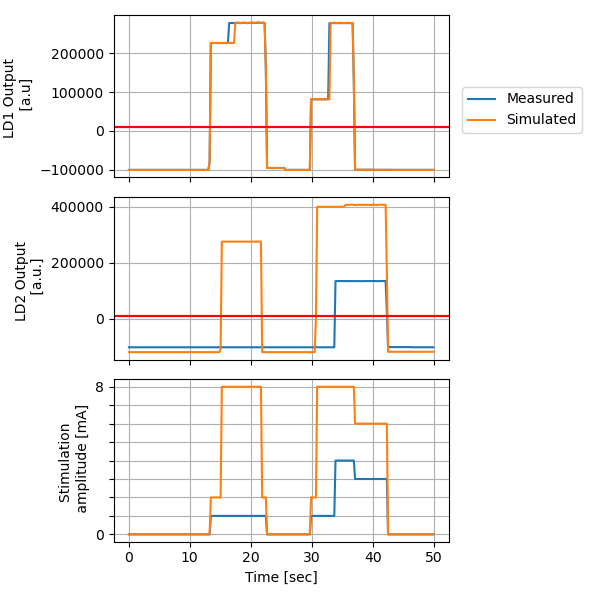

In [54]:
# %matplotlib widget
fig, ax = plt.subplots(3,1, figsize=(6,6), sharex='col', sharey=False)

ax[0].plot(data_meas.loc[~np.isnan(data_meas.ld1), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.ld1), 'ld1'], label='Measured')
ax[0].plot(data_sim.loc[~np.isnan(data_sim.ld1_iso), 'timestamp'], 
           data_sim.loc[~np.isnan(data_sim.ld1_iso), 'ld1_iso'], 
           label='Simulated')
ax[0].axhline(settings.threshold[0][0][0], color='r')
ax[0].axhline(settings.threshold[0][0][1], color='r')
ax[0].legend(bbox_to_anchor=(1.02, 0.6))

ax[1].plot(data_meas.loc[~np.isnan(data_meas.ld2), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.ld2), 'ld2'], label='Measured')
ax[1].plot(data_sim.loc[~np.isnan(data_sim.ld2_iso), 'timestamp'], 
           data_sim.loc[~np.isnan(data_sim.ld2_iso), 'ld2_iso'], 
           label='Simulated')
ax[1].axhline(settings.threshold[0][1][0], color='r')
ax[1].axhline(settings.threshold[0][1][1], color='r')

ax[2].plot(data_meas.loc[~np.isnan(data_meas.state), 'timestamp'], 
           data_meas.loc[~np.isnan(data_meas.state), 'state'], label='Measured')
# ax[2].plot(data_sim.loc[~np.isnan(data_sim.state_iso), 'timestamp'], 
#            data_sim.loc[~np.isnan(data_sim.state_iso), 'state_iso'], 
#            label='Simulated')
ax[2].plot(t_state, state, 
           label='Simulated')
ax[2].set_yticks(np.arange(9))
ax[2].set_yticklabels(['0'] + ['']*7 + ['8'])

for i in range(3):
    ax[i].grid()
ax[2].set_xlabel('Time [sec]')
ax[0].set_ylabel('LD1 Output \n [a.u]')
ax[1].set_ylabel('LD2 Output \n [a.u.]')
ax[2].set_ylabel('LD State')
ax[2].set_ylabel('Stimulation \n amplitude [mA]')

plt.tight_layout()

In [63]:
os.chdir('/media/shortterm_ssd/dlawrence/rclone/rcssim_testing/csv')

In [64]:
amp_gains = pd.read_csv('amp_gains.csv')

In [63]:
os.chdir('/media/shortterm_ssd/dlawrence/rclone/rcssim_testing/csv')

In [64]:
amp_gains = pd.read_csv('amp_gains.csv')

In [63]:
os.chdir('/media/shortterm_ssd/dlawrence/rclone/rcssim_testing/csv')

In [64]:
amp_gains = pd.read_csv('amp_gains.csv')